In [8]:
# Dev env: Python     3.10.9
#          pandas     2.1.3
#          numpy      1.26.2 <-- 預計兼容 1.23
#          matplotlib 3.8.2
#          seaborn    0.13.0

# 請注意執行前須要把 notebook 跟檔案放在同一個資料夾
filename   = '[Adt Income] adult_test.csv'
list_target_col = [] # 留空代表全畫，如果不為空，則只畫這些欄位
filetag    = ''  # 留空代表不加tag，輸出圖片用，會接在 filetag 後面
fig_ratio  = 1.6 # 長寬比，不滿意出圖就調整這裡
                 # 我自己測單個變數設 0.3、多個變數設 1.6

# 如果有畫不出來的欄位，可以去 df_metadata 檢查 parsed_dtype 看是不是被判斷成 error
monitor_width = 2400     # 建議不變
monitor_dpi   =  150     # 建議不變 # detect monitor DPI: https://www.infobyip.com/detectmonitordpi.php
variable_col  =    3     # 建議不變
color_palette = 'pastel' # 建議不變（SNS預設）
                         # 頂多考慮 colorblind（適合色盲但辨識度低）跟 viridis（高對比兼適合色盲但醜）



###### ###### ###### ###### ###### ######
# 20231122, Justyn: 1. 自動抓foldername為目前工作目錄，避免大數據平台之絕對路徑、對使用者較難取得
#                   2. 修正 NA 異常情況：使用 np.all(np.isnan(ncol_data)) 預先檢核
#                      可處理包含『第一筆0.0後面空』、『第一筆0後面空』、『全部空』的無括號各情境
#                   3. 修正 float 應為 finfo 而非 iinfo
#                   >> 現場 workaround 由於強制改用 object、故測試發現 np.unique 無法執行
#                      目前修正後可將類似情況順利轉為 category，如有問題，請再協助提供第一個 cell 所報的版本號
###### ###### ###### ###### ###### ######
import sys
import pandas as pd
import numpy  as np
import matplotlib
import seaborn as sns
for __libname ,__lib in {'Python    ' : sys
                        ,'pandas    ' : pd
                        ,'numpy     ' : np
                        ,'matplotlib' : matplotlib
                        ,'seaborn   ' : sns
                        }.items():
    __version_raw = __lib.version if __libname == 'Python    ' else __lib.__version__
    __version     = __version_raw.split('.')
    __version     = f"{__version[0]}.{format(int(__version[1]) ,'02')}"
    print(f"Current {__libname} version is {__version} ({__version_raw}).")
    if __libname == 'numpy     ':
        np_version = __version
# import numpy as np
# np_version = np.__version__.split('.')
# np_version = float(f"{np_version[0]}.{format(int(np_version[1]) ,'02')}")
# print(f"Current pandas version is {np_version} ({np.__version__}).")
# print(f"Current numpy  version is {np_version} ({np.__version__}).")
###### ###### ###### ###### ###### ######
# 虛擬環境切換
# - pytz 隨 pandas 安裝
###### ###### ######
# python -m venv mohw_env$
# mohw_env\Scripts\activate
# pip install jupyter pandas numpy==1.23 matplotlib seaborn
# 選擇正確的Python核心
# deactivate
# rmdir /s /q mohw_env

Current Python     version is 3.10 (3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]).
Current pandas     version is 2.01 (2.1.3).
Current numpy      version is 1.23 (1.23.0).
Current matplotlib version is 3.08 (3.8.2).
Current seaborn    version is 0.13 (0.13.0).


In [9]:
import os
# foldername = 'D:\Dropbox\89_其他應用\GitHub\PETs-Experiment\data'.replace("\\", "\\\\")
foldername   = os.getcwd()
fullfilepath = os.path.join(foldername ,filename)
print(f"Fullfile from {fullfilepath}")
file_name ,file_extension = os.path.splitext(os.path.basename(fullfilepath))
from datetime import datetime
import pytz
exectime = datetime.now().astimezone(pytz.timezone('Asia/Taipei'))
outputname = f"{filename}_{exectime.strftime('%Y%m%d_%H%M%S')}"\
          if filetag == ''\
        else f"{filename}_{filetag}_{exectime.strftime('%Y%m%d_%H%M%S')}"
print(f"Output file will be {outputname}")

Fullfile from d:\Dropbox\89_其他應用\GitHub\PETs-Experiment\[Adt Income] adult_test.csv
Output file will be [Adt Income] adult_test.csv_20231122_171331


              index    dtype parsed_dtype   nobs  is_unique  missing  \
0               age    int64         int8  48842      False    False   
1         workclass   object     category  48842      False    False   
2            fnlwgt    int64        int32  48842      False    False   
3         education   object     category  48842      False    False   
4   educational-num    int64         int8  48842      False    False   
5    marital-status   object     category  48842      False    False   
6        occupation   object     category  48842      False    False   
7      relationship   object     category  48842      False    False   
8              race   object     category  48842      False    False   
9     test_float0.0  float64      float16  48842      False     True   
10        test_int0  float64      float16  48842      False     True   
11    test_allempty  float64      float16  48842      False     True   
12           gender   object     category  48842      False    F

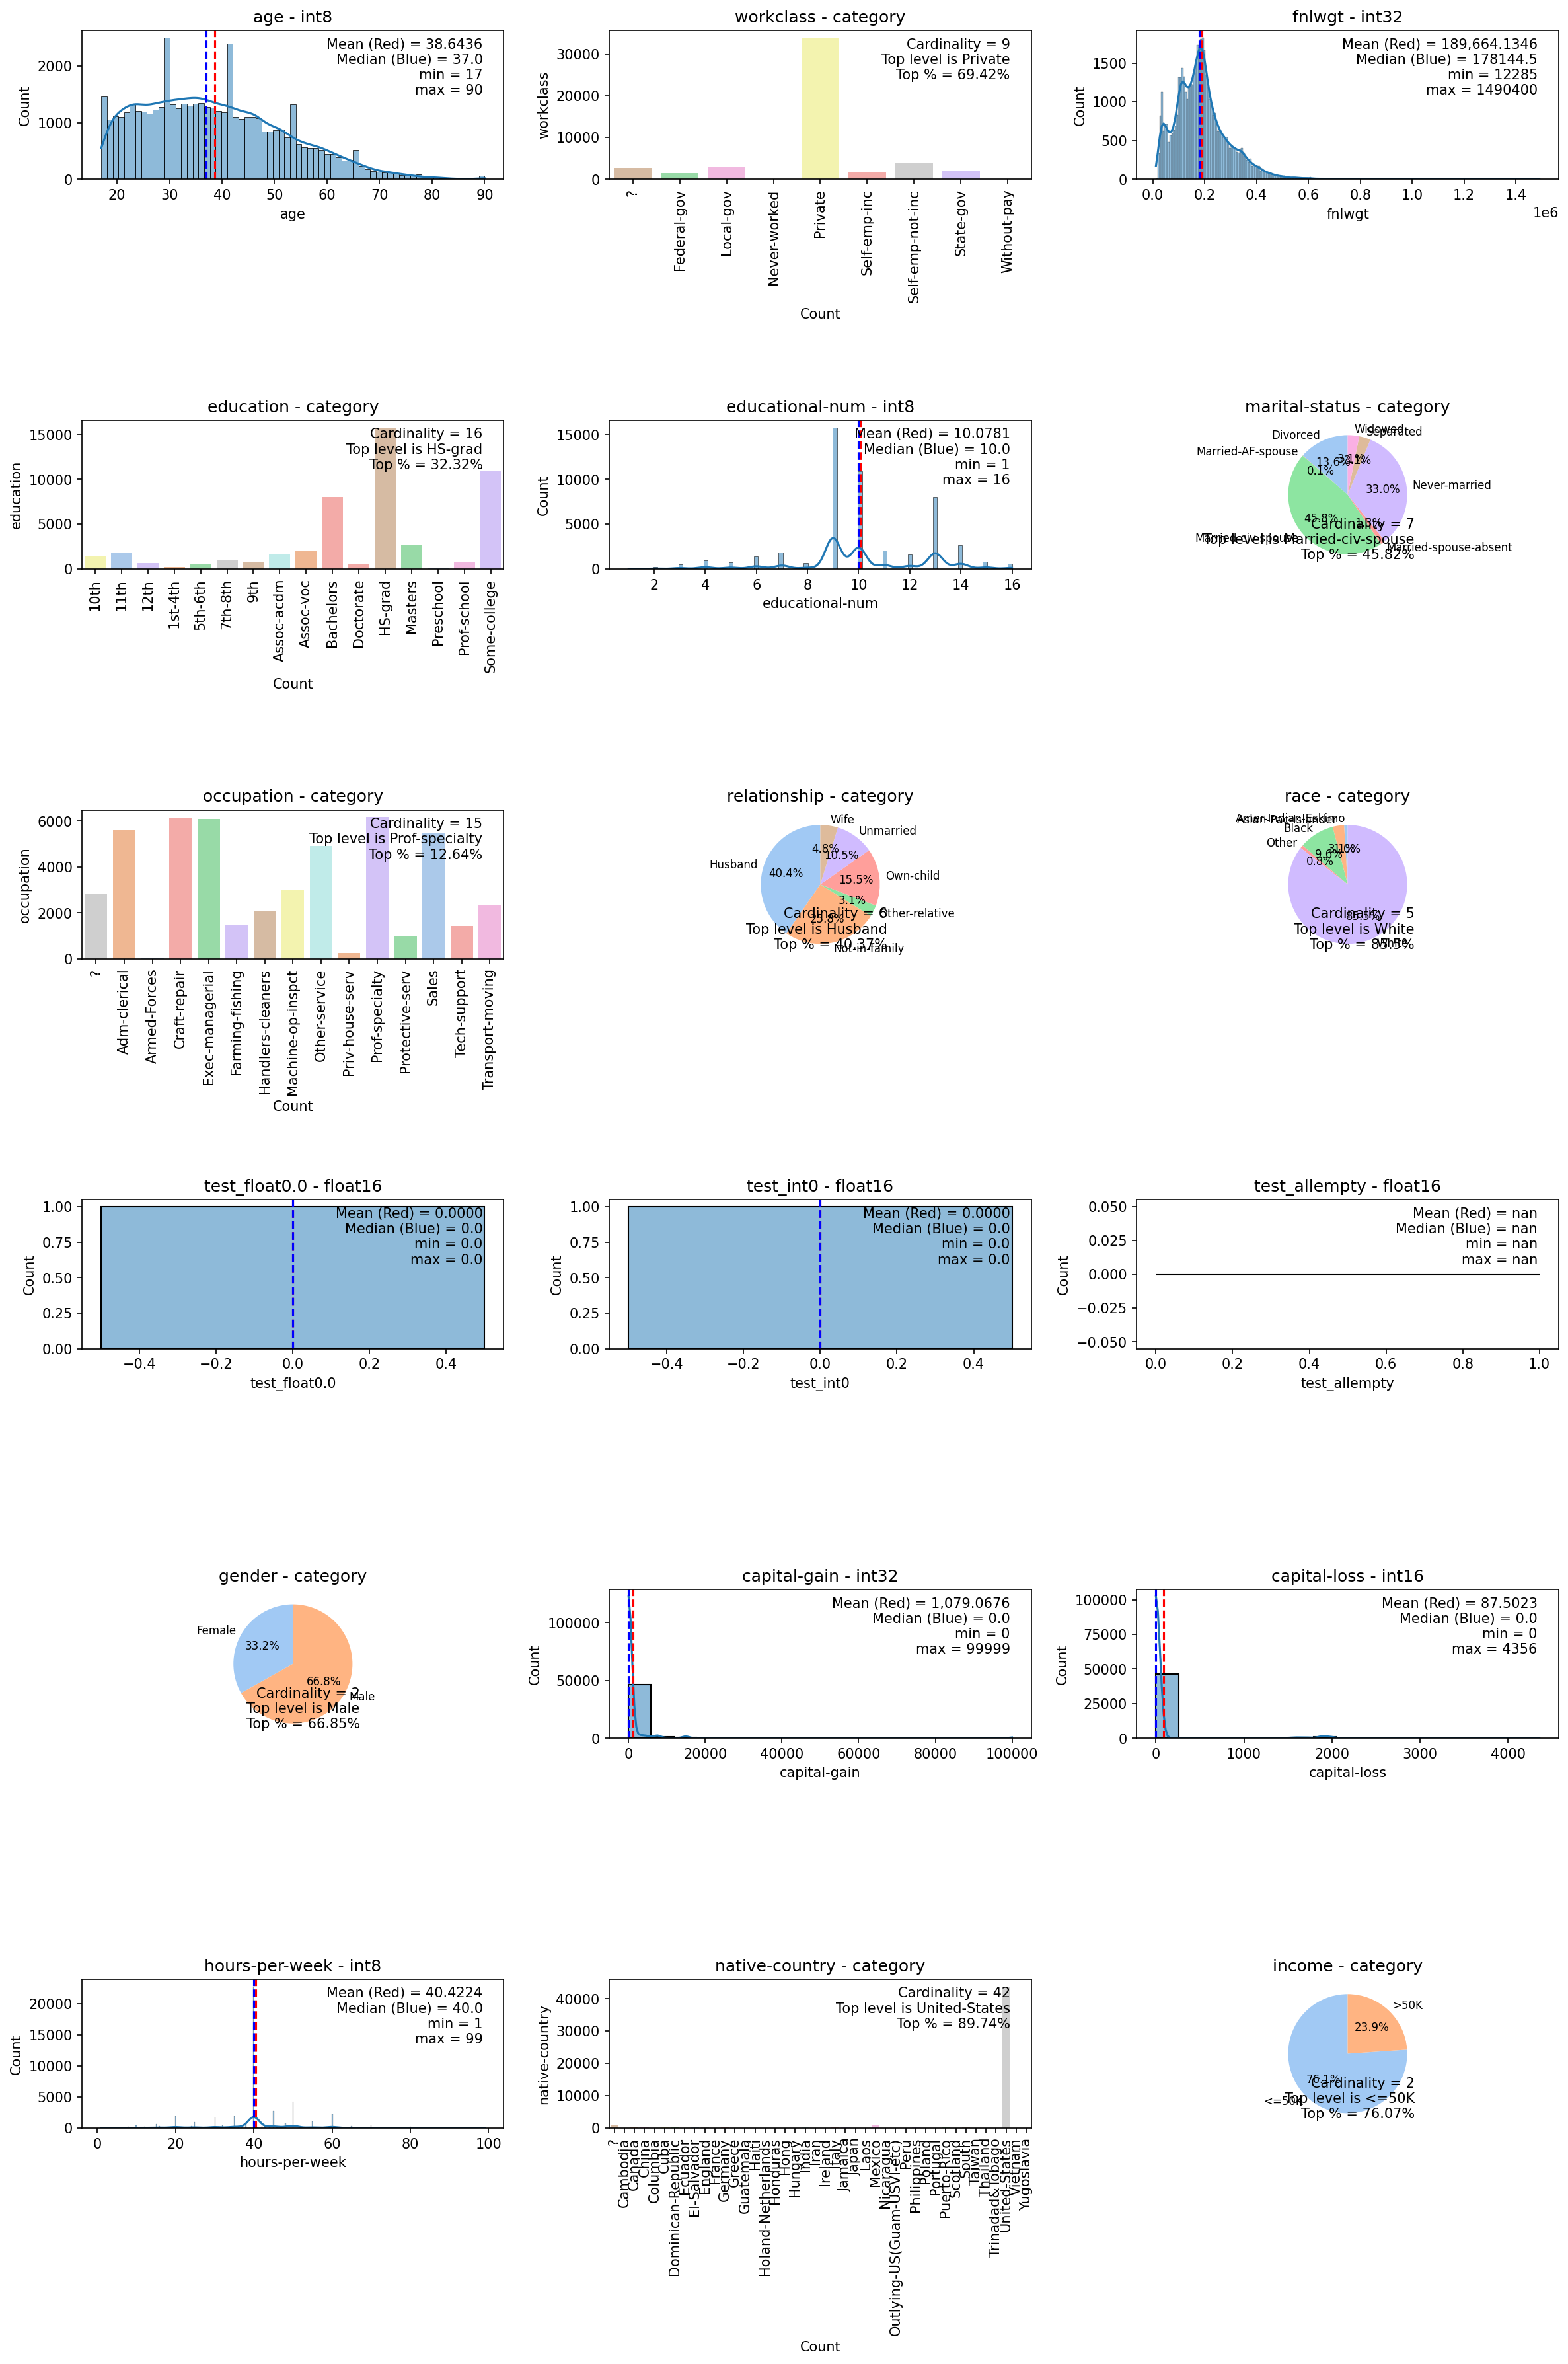

In [11]:
###### ###### ###### ###### ###### ######
# 仿 PETs_Describer + PETs_Util (ver.231121) #
###### ###### ###### ###### ###### ######
def df_parsed_metadata(df_data):
    def __is_date_datetime(col_data):
        from pandas.api.types import is_string_dtype ,is_numeric_dtype\
                                    ,is_integer_dtype ,is_float_dtype
        if is_string_dtype(col_data):
            from dateutil.parser import parse
            __cnt_date ,__cnt_datetime ,__cnt_category = 0,0,0
            for __value in col_data.dropna():
                try:
                    parsed_col_data = parse(col_data)
                    if parsed_col_data.hour   == 0\
                   and parsed_col_data.minute == 0\
                   and parsed_col_data.second == 0:
                        __cnt_date += 1
                    else:
                        __cnt_date += 1 
                except (ValueError, TypeError):
                    __cnt_category += 1
                
            if __cnt_category >= max(__cnt_date, __cnt_datetime):
                return 'category' # categorized if most of data couldn't been recognized as date
            elif __cnt_datetime >= 1:
                return 'datetime' # any time should be kept
            else:
                return 'date'
        elif is_numeric_dtype(col_data):
            import numpy as np
            __col_min = 0.0 if np.all(np.isnan(col_data)) else np.nanmin(col_data)
            __col_max = 0.0 if np.all(np.isnan(col_data)) else np.nanmax(col_data)
            if is_integer_dtype(col_data):
                if   np.iinfo( np.int8).min < __col_min <= __col_max < np.iinfo( np.int8).max:
                    return 'int8'
                elif np.iinfo(np.int16).min < __col_min <= __col_max < np.iinfo(np.int16).max:
                    return 'int16'
                elif np.iinfo(np.int32).min < __col_min <= __col_max < np.iinfo(np.int32).max:
                    return 'int32'
                else:
                    return 'int64'
            elif is_float_dtype(col_data):
                if   np.finfo(np.float16).min < __col_min <= __col_max < np.finfo(np.float16).max:
                    return 'float16'
                elif np.finfo(np.float32).min < __col_min <= __col_max < np.finfo(np.float32).max:
                    return 'float32'
                else:
                    return 'float64'
            else:
                return 'numeric-other'
        else:
            return 'error'

    import numpy  as np
    import pandas as pd
    __dict_metadata = {}
    for __col_name in df_data.columns:
        __col_data = df_data[__col_name]
        __dict_metadata[__col_name] = {}

        __dict_metadata[__col_name]['dtype'       ] = __col_data.dtype
        __parsed_dtype = __is_date_datetime(__col_data)
        __dict_metadata[__col_name]['parsed_dtype'] = __parsed_dtype

        __nobs = len(__col_data)
        __dict_metadata[__col_name]['nobs'] = __nobs

        __dict_metadata[__col_name]['is_unique'] = __col_data.is_unique

        __missing = __col_data.isnull()
        __dict_metadata[__col_name]['missing'     ] = __missing.any()
        __dict_metadata[__col_name]['missing_freq'] = ((__missing.sum() / __nobs)*100).round(2).astype(str)+'%'

        if __parsed_dtype in ['category' ,'date' ,'datetime']:
            __unique ,__counts = np.unique(__col_data ,return_counts=True)
            __top_indexes = np.where(__counts == max(__counts))[0]
            __top_count   = set([__counts[index] for index in __top_indexes]).pop()
            __dict_metadata[__col_name]['cat_cardinality'] = len(__unique)
            __dict_metadata[__col_name]['cat_top'        ] = '|'.join([__unique[index] for index in __top_indexes])
            __dict_metadata[__col_name]['cat_top_per'    ] = ((__top_count / __nobs)*100).round(2).astype(str)+'%'
        else:
            __dict_metadata[__col_name]['cat_cardinality'] = pd.NA
            __dict_metadata[__col_name]['cat_top'        ] = pd.NA
            __dict_metadata[__col_name]['cat_top_per'    ] = pd.NA
        
        if any(__parsed_dtype.startswith(prefix) for prefix in ['int' ,'float' ,'numeric']):
            __dict_metadata[__col_name]['num_mean'  ] = np.nan if np.all(np.isnan(__col_data)) else np.nanmean(  __col_data)
            __dict_metadata[__col_name]['num_min'   ] = np.nan if np.all(np.isnan(__col_data)) else np.nanmin(   __col_data)
            __dict_metadata[__col_name]['num_max'   ] = np.nan if np.all(np.isnan(__col_data)) else np.nanmax(   __col_data)
            __dict_metadata[__col_name]['num_median'] = np.nan if np.all(np.isnan(__col_data)) else np.nanmedian(__col_data)
        else:
            __dict_metadata[__col_name]['num_mean'  ] = pd.NA
            __dict_metadata[__col_name]['num_min'   ] = pd.NA
            __dict_metadata[__col_name]['num_max'   ] = pd.NA
            __dict_metadata[__col_name]['num_median'] = pd.NA

    return pd.DataFrame.from_dict(__dict_metadata ,orient='index')\
                        .reset_index(drop=False)



###### ###### ###### ###### ###### ######
# 做圖：Gridspec 控制 Seaborn 畫圖       #
###### ###### ###### ###### ###### ######
def df_vis(df_data ,df_metadata
          ,list_target_col
          ,monitor_width ,monitor_dpi ,fig_ratio ,variable_col
          ,color_palette
          ,outputname):
    


    ###### ###### ###### ###### ###### ######
    # 做圖：數值型變項                       #
    ###### ###### ###### ###### ###### ######
    def __plot_numeric(ax ,df_data ,col_name
                      ,mean ,median
                      ,min  ,max):
        import seaborn as sns
        sns.histplot(df_data[col_name] ,kde=True, ax=ax)
        ax.axvline(x=mean   ,color='r'    ,linestyle='--' ,label='Mean'  )
        ax.axvline(x=median ,color='blue' ,linestyle='--' ,label='Median')
        str_mean_median = f"Mean (Red) = {mean:,.4f}\nMedian (Blue) = {median}\nmin = {min}\nmax = {max}"
        ax.text(0.95 ,0.95 ,str_mean_median
            ,transform           = ax.transAxes
            ,horizontalalignment = 'right'
            ,verticalalignment   = 'top')



    ###### ###### ###### ###### ###### ######
    # 做圖：類別型變項                       #
    ###### ###### ###### ###### ###### ######
    def __plot_category(ax ,df_data ,col_name
                       ,cardinality ,top ,top_per ,color_palette):
        import seaborn as sns
        import warnings
        __data = df_data[col_name].value_counts().reset_index().sort_values(by=col_name)
        __data.columns = [col_name ,'count']
        if cardinality <= 8:
            __data.set_index(col_name)['count'].sort_index()\
                .plot.pie(autopct='%1.1f%%' ,ax=ax
                        ,startangle=90
                        ,colors=sns.color_palette(color_palette ,8)
                        ,textprops={'fontsize': 8})
            ax.set_ylabel('')
            str_top_x = 0.95
            str_top_y = 0.05
            str_top_horizontalalignment = 'right'
            str_top_verticalalignment   = 'bottom'
        else:
            # ignore UserWarning: The palette list has more values (42) than needed (38), which may not be intended.
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                # sns.color_palette("dark:#5A9_r", as_cmap=True))
                sns.barplot(data=__data ,x=col_name ,y='count'
                        ,hue='count' ,legend=False
                        ,ax=ax ,palette=sns.color_palette(color_palette ,cardinality))
            ax.set_xlabel('Count')
            ax.set_ylabel(col_name)
            ax.tick_params(axis='x', labelrotation=90)
            str_top_x = 0.95
            str_top_y = 0.95
            str_top_horizontalalignment = 'right'
            str_top_verticalalignment   = 'top'

        str_top = f"Cardinality = {cardinality}\nTop level is {top}\nTop % = {top_per}"
        ax.text(str_top_x ,str_top_y ,str_top
               ,transform           = ax.transAxes
               ,horizontalalignment = str_top_horizontalalignment
               ,verticalalignment   = str_top_verticalalignment)



    ###### ###### ###### ###### ###### ######
    # 做圖：日期型變項                       #
    ###### ###### ###### ###### ###### ######
    def __plot_date(ax, df_data ,col_name):
        import seaborn as sns
        sns.lineplot(data=df_data[col_name].value_counts().sort_index(), ax=ax)



    ###### ###### ###### ###### ###### ######
    # 資料篩選                               #
    ###### ###### ###### ###### ###### ######
    df_metadata = df_metadata[df_metadata['parsed_dtype'] != 'error']
    if len(list_target_col) != 0:
        df_metadata = df_metadata[df_metadata['index'].isin(list_target_col)]
    df_metadata = df_metadata.reset_index(drop=True)
    
    ###### ###### ###### ###### ###### ######
    # 設定畫布                               #
    ###### ###### ###### ###### ###### ######
    import matplotlib.pyplot   as plt
    import matplotlib.gridspec as gridspec
    variable_row = int(df_metadata.shape[0] / variable_col)+1
    graph_row    = variable_row # 預備擴展畫布之用
    fig = plt.figure(figsize = ((monitor_width/monitor_dpi)
                               ,(monitor_width/monitor_dpi)*fig_ratio)
                    ,dpi     = monitor_dpi)
    gs  = gridspec.GridSpec(graph_row ,variable_col ,figure=fig)
    
    for idx, row in df_metadata.iterrows():
        __ax = fig.add_subplot(gs[idx])
        __col_name     = row['index'       ]
        __parsed_dtype = row['parsed_dtype']

        if   any(__parsed_dtype.startswith(prefix) for prefix in ['int' ,'float' ,'numeric']):
            __plot_numeric(__ax ,df_data ,__col_name
                          ,row['num_mean'] ,row['num_median']
                          ,row['num_min' ] ,row['num_max'   ])
        elif __parsed_dtype == 'category':
            __plot_category(__ax ,df_data ,__col_name
                           ,row['cat_cardinality'] ,row['cat_top'] ,row['cat_top_per']
                           ,color_palette)
        elif __parsed_dtype in ['date', 'datetime']:
            __plot_date(__ax ,df_data ,__col_name)

        __ax.set_title(f"{__col_name} - {__parsed_dtype}")

    plt.tight_layout()
    plt.savefig(outputname+'.png'
               ,dpi=300 ,bbox_inches='tight')
    plt.show()

 



###### ###### ###### ###### ###### ######
# 自動、敘述性統計、視覺化工具
###### ###### ###### ###### ###### ######
def MOHW_desc_vis(fullfilepath
                 ,**kwargs):
    import pandas as pd
    try:
        df_data     = pd.read_csv(fullfilepath)
        df_metadata = df_parsed_metadata(df_data)
        print(df_metadata)
    except Exception as e:
        import warnings
        raise Exception("確認你的檔案是否是逗號分隔的csv，並且具有表頭(header)."+'\n'+e)
    df_vis(df_data ,df_metadata
          ,list_target_col
          ,monitor_width ,monitor_dpi ,fig_ratio ,variable_col
          ,color_palette
          ,outputname)
    return df_data ,df_metadata

df_data ,df_metadata =\
MOHW_desc_vis(fullfilepath
             ,list_target_col = list_target_col
             ,monitor_width   = monitor_width
             ,monitor_dpi     = monitor_dpi
             ,fig_ratio       = fig_ratio
             ,variable_col    = variable_col
             ,color_palette   = color_palette
             ,outputname      = outputname
             )